# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Standard Library Imports
import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd

# Image Processing and Visualization Libraries
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import functional as F

# PyTorch and Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

# Transformers and Pretrained Models
from transformers import DetrForObjectDetection, DetrImageProcessor

# Scikit-learn Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

# PyTorch Pretrained Models
import torchvision.models as models




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Update with your own save path
save_dir = "/content/drive/My Drive/Master Thesis/CholecT50"



# Load datasets and create dataloaders

In [ ]:
dataset = []
for i in range(5):
  dataset.extend(torch.load(f"{save_dir}/Datasets/frame_dataset{int(i*10)}_{int((i+1)*10)}.pt"))
  print(i)


<ipython-input-5-b04249c06fb6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset.extend(torch.load(f"/content/drive/My Drive/Master Thesis/CholecT50/frame_dataset{int

0
1
2
3
4


In [ ]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


def collate_fn(batch):
    max_objects = 10
    return {
        'frame': torch.stack([item['frame'] for item in batch]),
        'frame_caption': [item['frame_caption'] for item in batch],
        'object_labels': torch.stack([torch.tensor(item['object_labels']) for item in batch]),
        'objects': [
            item['objects'] + [''] * (max_objects - len(item['objects'])) if len(item['objects']) < max_objects
            else item['objects'][:max_objects] for item in batch
        ]
    }


batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# ViT

In [ ]:

class ViTForMultiLabel(nn.Module):
    def __init__(self, num_labels=21):
        super().__init__()
        self.vit = models.vit_b_16(pretrained=True)
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, num_labels)

    def forward(self, x):
        return self.vit(x)

# Compute class weights
label_counts = torch.tensor([69066, 6666, 52791, 2134, 3429, 4957, 1, 64226, 4645, 11628, 5006, 295, 411, 3091, 831, 14186, 228, 6396, 1102, 669, 4856], dtype=torch.float)
weights = 1.0 / (label_counts + 1e-6)
weights /= weights.sum()

# Initialize model
model = ViTForMultiLabel().to(device)
criterion = nn.BCEWithLogitsLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def run_epoch(model, loader, optimizer=None, train=True):
    mode = "Training" if train else "Validation"
    model.train() if train else model.eval()
    total_loss = 0
    total_batches = len(loader)

    for batch_idx, batch in enumerate(loader):
        frame = batch['frame'].to(device)
        labels = batch['object_labels'].to(device)

        if train:
            optimizer.zero_grad()
            outputs = model(frame)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        else:
            with torch.no_grad():
                outputs = model(frame)
                loss = criterion(outputs, labels)

        total_loss += loss.item()

        # Print progress bar
        progress = (batch_idx + 1) / total_batches
        bar_length = 20
        filled_length = int(bar_length * progress)
        bar = "=" * filled_length + " " * (bar_length - filled_length)
        percentage = int(progress * 100)
        sys.stdout.write(f"\r[{bar}] {percentage}% - Batch {batch_idx+1}/{total_batches} - Loss: {loss.item():.4f} - Avg {mode} Loss: {total_loss / (batch_idx + 1):.4f}")
        sys.stdout.flush()

    print()
    return total_loss / total_batches


optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()

# Train model
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}: ")
    train_loss = run_epoch(model, train_loader, optimizer, train=True)
    val_loss = run_epoch(model, val_loader, train=False)
    torch.save(model.state_dict(), f"{save_dir}/Models/model_OD.pth")


Epoch 1/5: 
[====================] 100% - Batch 8983/8983 - Loss: 0.0505 - Avg Training Loss: 0.0840
[====================] 100% - Batch 1123/1123 - Loss: 0.0793 - Avg Validation Loss: 0.0538
Epoch 2/5: 
[====================] 100% - Batch 8983/8983 - Loss: 0.0260 - Avg Training Loss: 0.0424
[====================] 100% - Batch 1123/1123 - Loss: 0.0295 - Avg Validation Loss: 0.0458
Epoch 3/5: 
[====================] 100% - Batch 8983/8983 - Loss: 0.0056 - Avg Training Loss: 0.0289
[====================] 100% - Batch 1123/1123 - Loss: 0.0530 - Avg Validation Loss: 0.0423
Epoch 4/5: 
[====================] 100% - Batch 8983/8983 - Loss: 0.0069 - Avg Training Loss: 0.0214
[====================] 100% - Batch 1123/1123 - Loss: 0.0230 - Avg Validation Loss: 0.0394
Epoch 5/5: 
[====================] 100% - Batch 8983/8983 - Loss: 0.0496 - Avg Training Loss: 0.0165
[====================] 100% - Batch 1123/1123 - Loss: 0.0269 - Avg Validation Loss: 0.0425


# Test

In [ ]:
preds_list  =[]
probs_list = []
labels_list = []
with torch.no_grad():
    for batch in test_loader:
        frames = batch['frame'].to(device)
        labels = batch['object_labels'].cpu().numpy()
        outputs = model(frames)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        preds_list.append(preds)
        probs_list.append(probs)
        labels_list.append(labels)


all_preds = np.array(preds_list)
all_probs = np.array(probs_list)
all_labels = np.array(labels_list)
all_preds = all_preds.flatten()
all_probs = all_probs.flatten()
all_labels = all_labels.flatten()
all_preds = all_preds.reshape(-1, 21)
all_labels = all_labels.reshape(-1, 21)



overall_precision = precision_score(all_labels, all_preds, average='micro')
overall_recall = recall_score(all_labels, all_preds, average='micro')
overall_f1 = f1_score(all_labels, all_preds, average='micro')
overall_accuracy = accuracy_score(all_labels, all_preds)
print("Overall Statistics:")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")
print(f"Accuracy: {overall_accuracy:.4f}")
print("\n")


label_precision = precision_score(all_labels, all_preds, average=None)
label_recall = recall_score(all_labels, all_preds, average=None)
label_f1 = f1_score(all_labels, all_preds, average=None)
print("Label-wise Statistics:")
print(f"{'Label Name':<20} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
for idx, (precision, recall, f1) in enumerate(zip(label_precision, label_recall, label_f1)):
    label_name = mapping.get(idx, "unknown")
    print(f"{label_name:<20} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")

Overall Statistics:
Precision: 0.9617
Recall: 0.9524
F1 Score: 0.9570
Accuracy: 0.8311


Label-wise Statistics:
Label Name           Precision  Recall     F1 Score  
grasper              0.9839     0.9673     0.9755    
bipolar              0.9737     0.8998     0.9353    
hook                 0.9627     0.9893     0.9758    
scissors             0.9005     0.8873     0.8938    
clipper              0.9329     0.8870     0.9094    
irrigator            0.9476     0.9163     0.9317    
specimen_bag         0.0000     0.0000     0.0000    
gallbladder          0.9758     0.9706     0.9732    
cystic_plate         0.8643     0.9370     0.8992    
cystic_duct          0.9066     0.8971     0.9018    
cystic_artery        0.9248     0.8120     0.8647    
cystic_pedicle       0.9474     0.6667     0.7826    
blood_vessel         0.9677     0.7692     0.8571    
fluid                0.8638     0.8142     0.8383    
abdominal_wall_cavity 0.6667     0.7105     0.6879    
liver                0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-13-18de6fe1fef6>:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/Master Thesis/CholecT50/model_OD

ECE before calibration: 0.0075
Optimal Temperature: 1.8584
ECE after calibration: 0.0028


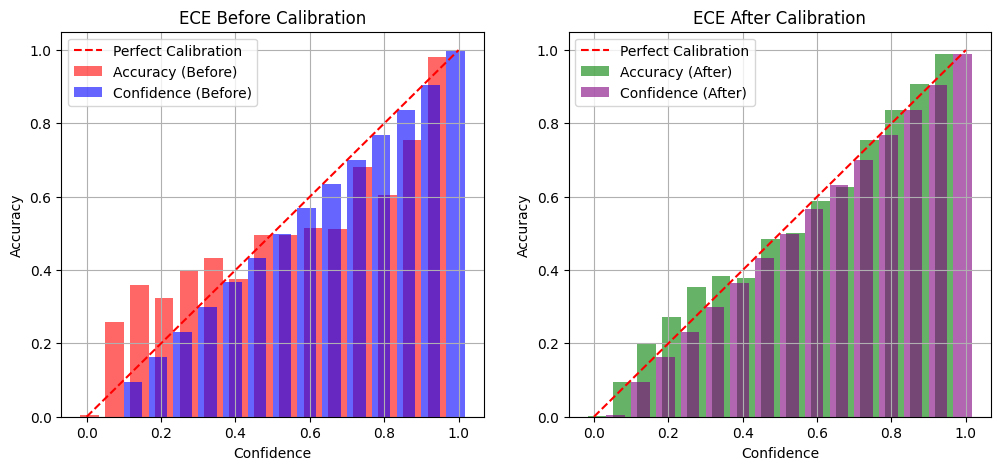

In [ ]:
class ViTForMultiLabel(nn.Module):
    def __init__(self, num_labels=21):
        super().__init__()
        self.vit = models.vit_b_16(pretrained=True)
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, num_labels)

    def forward(self, x):
        return self.vit(x)

class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return logits / self.temperature

def calibrate_temperature(model, val_loader, device):
    model.eval()
    temperature_scaling = TemperatureScaling().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.LBFGS([temperature_scaling.temperature], lr=0.01, max_iter=50)
    logits_list, labels_list = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['frame'].to(device), batch['object_labels'].to(device)
            logits = model(inputs)
            logits_list.append(logits)
            labels_list.append(labels)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)
    def closure():
        optimizer.zero_grad()
        loss = criterion(temperature_scaling(logits), labels)
        loss.backward()
        return loss

    optimizer.step(closure)
    print(f"Optimal Temperature: {temperature_scaling.temperature.item():.4f}")
    return temperature_scaling

def predict_with_temperature(model, temperature_scaling, test_loader, device):
    model.eval()
    temperature_scaling.eval()
    probs_list, labels_list = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['frame'].to(device), batch['object_labels'].to(device)
            logits = model(inputs)
            scaled_logits = temperature_scaling(logits)
            probs = torch.sigmoid(scaled_logits)
            probs_list.append(probs.cpu())
            labels_list.append(labels.cpu())

    return torch.cat(probs_list), torch.cat(labels_list)

# Compute Expected Calibration Error
def compute_ece(probs, labels, n_bins=15):
    bins = torch.linspace(0, 1, n_bins + 1)
    bin_lowers, bin_uppers = bins[:-1], bins[1:]
    ece = torch.zeros(1)
    bin_accs, bin_confs, bin_sizes = [], [], []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (probs > bin_lower) & (probs <= bin_upper)
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            acc_in_bin = labels[in_bin].float().mean()
            conf_in_bin = probs[in_bin].mean()
            ece += torch.abs(conf_in_bin - acc_in_bin) * prop_in_bin
            bin_accs.append(acc_in_bin.item())
            bin_confs.append(conf_in_bin.item())
            bin_sizes.append(prop_in_bin.item())

    return ece.item(), bin_accs, bin_confs, bin_sizes

# Plot ECE
def plot_ece_separate(bin_accs_before, bin_confs_before, bin_accs_after, bin_confs_after):
    bin_edges = np.linspace(0, 1, len(bin_accs_before) + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = 0.05

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Before Calibration
    axes[0].bar(bin_centers - width/2, bin_accs_before, width=width, color='red', alpha=0.6, label="Accuracy (Before)")
    axes[0].bar(bin_centers + width/2, bin_confs_before, width=width, color='blue', alpha=0.6, label="Confidence (Before)")
    axes[0].plot([0, 1], [0, 1], '--', color="red", label="Perfect Calibration")
    axes[0].set_xlabel("Confidence")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("ECE Before Calibration")
    axes[0].legend()
    axes[0].grid()

    # Plot After Calibration
    axes[1].bar(bin_centers - width/2, bin_accs_after, width=width, color='green', alpha=0.6, label="Accuracy (After)")
    axes[1].bar(bin_centers + width/2, bin_confs_after, width=width, color='purple', alpha=0.6, label="Confidence (After)")
    axes[1].plot([0, 1], [0, 1], '--', color="red", label="Perfect Calibration")
    axes[1].set_xlabel("Confidence")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("ECE After Calibration")
    axes[1].legend()
    axes[1].grid()



    plt.show()

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForMultiLabel().to(device)
model.load_state_dict(torch.load(f"{save_dir}/Models/model_OD.pth"))

# Compute ECE Before Calibration
probs_before, labels = predict_with_temperature(model, nn.Identity(), test_loader, device)
ece_before, bin_accs_before, bin_confs_before, _ = compute_ece(probs_before, labels)
print(f"ECE before calibration: {ece_before:.4f}")

# Train and Apply Temperature Scaling
temperature_scaling = calibrate_temperature(model, val_loader, device)
probs_after, labels = predict_with_temperature(model, temperature_scaling, test_loader, device)
ece_after, bin_accs_after, bin_confs_after, _ = compute_ece(probs_after, labels)
print(f"ECE after calibration: {ece_after:.4f}")

plot_ece_separate(bin_accs_before, bin_confs_before, bin_accs_after, bin_confs_after)


# Store Predicted Objects

In [ ]:
mapping = {0: "grasper", 1: "bipolar", 2: "hook", 3: "scissors", 4: "clipper", 5: "irrigator", 6: "specimen_bag", 7: "gallbladder",
           8: "cystic_plate", 9: "cystic_duct", 10: "cystic_artery", 11: "cystic_pedicle", 12: "blood_vessel", 13: "fluid",
           14: "abdominal_wall_cavity", 15: "liver", 16: "adhesion", 17: "omentum", 18: "peritoneum", 19: "gut", 20: "specimen_bag", 21: "null_target"}

In [ ]:
batch_size = 1
loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
ObjectDetector = ViTForMultiLabel().to(device)
ObjectDetector.load_state_dict(torch.load(f"{save_dir}/Models/model_OD.pth"))

In [ ]:
def predict_dataset(ObjectDetector, loader, device):
    prediction_dataset = {}
    total_batches = len(loader)

    for batch_idx, batch in enumerate(loader):
        with torch.no_grad():
            frame = batch['frame'].to(device)
            objects = batch['objects']
            frame_caption = batch['frame_caption']
            video_folder = batch['video']
            frame_name = batch['frame_number']

            # Get objects
            output = ObjectDetector(frame)
            probs = torch.sigmoid(output)
            predicted_objects = [[mapping[i] for i in range(len(prob)) if prob[i] >= 0.5] for prob in probs]
            predicted_objects = [obj_list + [""] * (10 - len(obj_list)) if len(obj_list) < 10 else obj_list[:10] for obj_list in objects]


            # Store
            if video_folder[0] not in prediction_dataset:
                prediction_dataset[video_folder[0]] = {}
            prediction_dataset[video_folder[0]][frame_name[0]] = {
                "predicted_objects": objects[0],
            }

            # Print progress bar
            progress = (batch_idx + 1) / total_batches
            bar_length = 20
            filled_length = int(bar_length * progress)
            bar = "=" * filled_length + " " * (bar_length - filled_length)
            percentage = int(progress * 100)
            sys.stdout.write(f"\r[{bar}] {percentage}% - Batch {batch_idx+1}/{total_batches}")
            sys.stdout.flush()

    return prediction_dataset

prediction_dataset = predict_dataset(ObjectDetector, loader, device)

# Save to JSON file
save_path = f"{save_dir}/Predictions/predicted_objects.json"
with open(save_path, "w") as f:
    json.dump(prediction_dataset, f, indent=4)

[====================] 100% - Batch 89827/89827